In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import optuna


c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargar los datos
data = pd.read_csv('../../data/df_joint.csv', index_col='Date', parse_dates=True)   

In [11]:
data

,eurusd,jpyusd,gbpusd,nq,sp500,nikkei,ftse,gdp_us,gdp_uk,gdp_jp,...,unrate_ez,m0_us,m0_jp,m0_ez,ir_us,ir_uk,ir_deposit_ez,ir_lending_ez,ir_MRO_ez,ir_jp
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,1.258194,0.009320,1.785204,1468.00,1111.920044,10676.639648,4476.899902,11923.447,322790.0,529365.1,...,9.4,736400.0,1060327,548711.0,1.0,3.75,1.0,3.00,2.0,0.1
2004-01-02,1.258194,0.009354,1.793690,1466.50,1108.479980,10676.639648,4510.200195,11923.447,322790.0,529365.1,...,9.4,736400.0,1060327,548711.0,1.0,3.75,1.0,3.00,2.0,0.1
2004-01-05,1.268698,0.009413,1.807207,1495.50,1122.219971,10825.169922,4513.299805,11923.447,322790.0,529365.1,...,9.4,736400.0,1060327,548711.0,1.0,3.75,1.0,3.00,2.0,0.1
2004-01-06,1.272103,0.009414,1.821295,1504.50,1123.670044,10813.990234,4505.200195,11923.447,322790.0,529365.1,...,9.4,736400.0,1060327,548711.0,1.0,3.75,1.0,3.00,2.0,0.1
2004-01-07,1.264095,0.009418,1.817785,1517.00,1126.329956,10757.820312,4473.000000,11923.447,322790.0,529365.1,...,9.4,736400.0,1060327,548711.0,1.0,3.75,1.0,3.00,2.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1.066780,0.007531,1.206001,11075.25,3844.820068,26405.869141,7473.000000,26408.405,645805.0,568061.1,...,6.7,5406000.0,6293987,6385741.0,4.1,3.50,2.0,2.75,2.5,0.3
2022-12-27,1.064022,0.007532,1.208415,10915.50,3829.250000,26447.869141,7473.000000,26408.405,645805.0,568061.1,...,6.7,5406000.0,6293987,6385741.0,4.1,3.50,2.0,2.75,2.5,0.3
2022-12-28,1.063717,0.007491,1.202733,10772.75,3783.219971,26340.500000,7497.200195,26408.405,645805.0,568061.1,...,6.7,5406000.0,6293987,6385741.0,4.1,3.50,2.0,2.75,2.5,0.3


In [3]:
# Reemplazar las comas por puntos para convertir a float
data['ir_uk'] = data['ir_uk'].str.replace(',', '.')
data['ir_uk'] = data['ir_uk'].astype(float)

# JPY/USD

In [4]:
# Seleccionar las características y los objetivos
features = data[['eurusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk',
       'ir_deposit_ez', 'ir_lending_ez', 'ir_MRO_ez', 'ir_jp']]


In [5]:
# Crear la columna objetivo: variación del precio
target_jpyusd = data['jpyusd']
target_variation_jpyusd = target_jpyusd.pct_change().shift(-1).dropna()

# Alinear las características con el objetivo
features_jpyusd = features.loc[target_variation_jpyusd.index]

# Escalar los datos
scaler_features_jpyusd = StandardScaler()
features_scaled_jpyusd = scaler_features_jpyusd.fit_transform(features_jpyusd)

scaler_target_jpyusd = StandardScaler()
target_scaled_jpyusd = scaler_target_jpyusd.fit_transform(target_variation_jpyusd.values.reshape(-1, 1))

# Crear las secuencias para LSTM
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X_jpyusd, y_jpyusd = create_sequences(features_scaled_jpyusd, target_scaled_jpyusd, time_steps)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_jpyusd, X_test_jpyusd, y_train_jpyusd, y_test_jpyusd = train_test_split(X_jpyusd, y_jpyusd, test_size=0.2, shuffle=False)


In [6]:
# Función de objetivo para Optuna
def objective_jpyusd(trial):
    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 50, 200), return_sequences=True, input_shape=(X_train_jpyusd.shape[1], X_train_jpyusd.shape[2])))
    model.add(Dropout(trial.suggest_float('dropout1', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units2', 50, 200), return_sequences=True))
    model.add(Dropout(trial.suggest_float('dropout2', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units3', 50, 200)))
    model.add(Dropout(trial.suggest_float('dropout3', 0.2, 0.5)))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('lr', 1e-4, 1e-2)), loss='mean_squared_error')

    model.fit(X_train_jpyusd, y_train_jpyusd, epochs=trial.suggest_int('epochs', 10, 50), batch_size=trial.suggest_int('batch_size', 16, 64), verbose=0)
    loss = model.evaluate(X_test_jpyusd, y_test_jpyusd, verbose=0)
    return loss


In [7]:
# Crear el estudio Optuna y optimizar
study_jpyusd = optuna.create_study(direction='minimize')
study_jpyusd.optimize(objective_jpyusd, n_trials=50)

# Imprimir los mejores hiperparámetros
print(study_jpyusd.best_trial)


[I 2024-06-04 13:37:17,245] A new study created in memory with name: no-name-7dfc1d83-784d-4c63-a3a5-96a7d6885af2
c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-06-04 13:37:40,814] Trial 0 finished with value: 0.4923044443130493 and parameters: {'units1': 178, 'dropout1': 0.2703195944315557, 'units2': 88, 'dropout2': 0.3099681893632082, 'units3': 95, 'dropout3': 0.23071507558880677, 'lr': 0.004098423698732202, 'epochs': 19, 'batch_size': 35}. Best is trial 0 with value: 0.4923044443130493.
[I 2024-06-04 13:38:04,710] Trial 1 finished with value: 0.4894159734249115 and parameters: {'units1': 102, 'dropout1': 0.30589999869246876, 'units2': 90, 'dropout2': 0.40300417622237605, 'units3': 142, 'dropout3': 0.4017083877499209, 'lr': 0.0

FrozenTrial(number=9, state=TrialState.COMPLETE, values=[0.4868268072605133], datetime_start=datetime.datetime(2024, 6, 4, 13, 42, 36, 696847), datetime_complete=datetime.datetime(2024, 6, 4, 13, 43, 8, 928650), params={'units1': 136, 'dropout1': 0.25123688128492117, 'units2': 168, 'dropout2': 0.26536545925980537, 'units3': 119, 'dropout3': 0.3762802872228267, 'lr': 0.002451386281320452, 'epochs': 24, 'batch_size': 37}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'units1': IntDistribution(high=200, log=False, low=50, step=1), 'dropout1': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'units2': IntDistribution(high=200, log=False, low=50, step=1), 'dropout2': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'units3': IntDistribution(high=200, log=False, low=50, step=1), 'dropout3': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'lr': FloatDistribution(high=0.01, log=False, low=0.0001, step=None), 'epochs': IntDistribution(h

In [8]:
# Entrenar el mejor modelo con los mejores hiperparámetros
best_params_jpyusd = study_jpyusd.best_params
model_jpyusd = Sequential()
model_jpyusd.add(LSTM(units=best_params_jpyusd['units1'], return_sequences=True, input_shape=(X_train_jpyusd.shape[1], X_train_jpyusd.shape[2])))
model_jpyusd.add(Dropout(best_params_jpyusd['dropout1']))
model_jpyusd.add(LSTM(units=best_params_jpyusd['units2'], return_sequences=True))
model_jpyusd.add(Dropout(best_params_jpyusd['dropout2']))
model_jpyusd.add(LSTM(units=best_params_jpyusd['units3']))
model_jpyusd.add(Dropout(best_params_jpyusd['dropout3']))
model_jpyusd.add(Dense(1))

model_jpyusd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_jpyusd['lr']), loss='mean_squared_error')

model_jpyusd.fit(X_train_jpyusd, y_train_jpyusd, epochs=best_params_jpyusd['epochs'], batch_size=best_params_jpyusd['batch_size'], verbose=1)


Epoch 1/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1.0837
Epoch 2/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1837
Epoch 3/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0534
Epoch 4/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8800
Epoch 5/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9905
Epoch 6/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9631
Epoch 7/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0445
Epoch 8/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8785
Epoch 9/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6189
Epoch 10/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3950
Epoch 11/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9347
Epoch 12/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0032
Epoch 13/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9775
Epoch 14/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0333
Epoch 15/24
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s

In [9]:
# Evaluar el modelo
loss_jpyusd = model_jpyusd.evaluate(X_test_jpyusd, y_test_jpyusd)
print(f'Model Loss for JPY/USD: {loss_jpyusd}')


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3443
Model Loss for JPY/USD: 0.4908450245857239


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


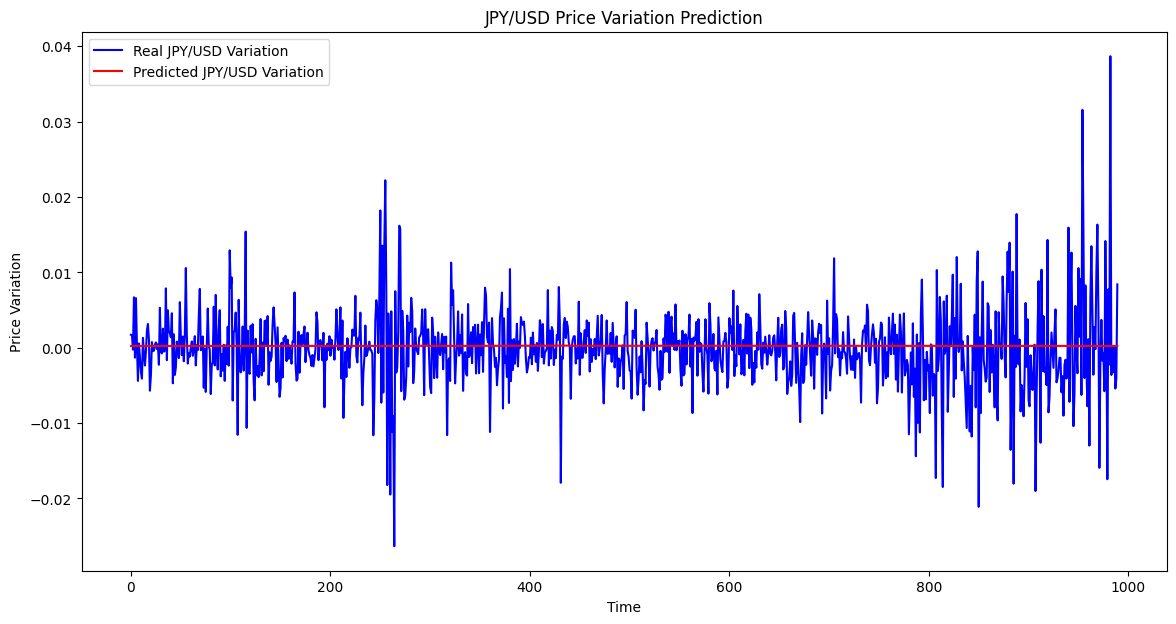

In [10]:
import matplotlib.pyplot as plt

# Hacer predicciones en el conjunto de prueba
y_pred_jpyusd = model_jpyusd.predict(X_test_jpyusd)
y_pred_jpyusd = scaler_target_jpyusd.inverse_transform(y_pred_jpyusd)
y_test_jpyusd = scaler_target_jpyusd.inverse_transform(y_test_jpyusd)

# Graficar los resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test_jpyusd, color='blue', label='Real JPY/USD Variation')
plt.plot(y_pred_jpyusd, color='red', label='Predicted JPY/USD Variation')
plt.title('JPY/USD Price Variation Prediction')
plt.xlabel('Time')
plt.ylabel('Price Variation')
plt.legend()
plt.show()


# GBP/USD

In [12]:
# Seleccionar las características y los objetivos
features = data[['eurusd', 'jpyusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk',
       'ir_deposit_ez', 'ir_lending_ez', 'ir_MRO_ez', 'ir_jp']]


In [13]:
# Crear la columna objetivo: variación del precio
target_gbpusd = data['gbpusd']
target_variation_gbpusd = target_gbpusd.pct_change().shift(-1).dropna()

# Alinear las características con el objetivo
features_gbpusd = features.loc[target_variation_gbpusd.index]

# Escalar los datos
scaler_features_gbpusd = StandardScaler()
features_scaled_gbpusd = scaler_features_gbpusd.fit_transform(features_gbpusd)

scaler_target_gbpusd = StandardScaler()
target_scaled_gbpusd = scaler_target_gbpusd.fit_transform(target_variation_gbpusd.values.reshape(-1, 1))

# Crear las secuencias para LSTM
X_gbpusd, y_gbpusd = create_sequences(features_scaled_gbpusd, target_scaled_gbpusd, time_steps)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_gbpusd, X_test_gbpusd, y_train_gbpusd, y_test_gbpusd = train_test_split(X_gbpusd, y_gbpusd, test_size=0.2, shuffle=False)


In [14]:
# Función de objetivo para Optuna
def objective_gbpusd(trial):
    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 50, 200), return_sequences=True, input_shape=(X_train_gbpusd.shape[1], X_train_gbpusd.shape[2])))
    model.add(Dropout(trial.suggest_float('dropout1', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units2', 50, 200), return_sequences=True))
    model.add(Dropout(trial.suggest_float('dropout2', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units3', 50, 200)))
    model.add(Dropout(trial.suggest_float('dropout3', 0.2, 0.5)))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('lr', 1e-4, 1e-2)), loss='mean_squared_error')

    model.fit(X_train_gbpusd, y_train_gbpusd, epochs=trial.suggest_int('epochs', 10, 50), batch_size=trial.suggest_int('batch_size', 16, 64), verbose=0)
    loss = model.evaluate(X_test_gbpusd, y_test_gbpusd, verbose=0)
    return loss


In [15]:
# Crear el estudio Optuna y optimizar
study_gbpusd = optuna.create_study(direction='minimize')
study_gbpusd.optimize(objective_gbpusd, n_trials=50)

# Imprimir los mejores hiperparámetros
print(study_gbpusd.best_trial)


[I 2024-06-04 14:23:52,806] A new study created in memory with name: no-name-79282fe5-68ed-46cc-8d07-e037cb3ee7e9
c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-06-04 14:24:51,061] Trial 0 finished with value: 1.0283851623535156 and parameters: {'units1': 119, 'dropout1': 0.455864094138464, 'units2': 95, 'dropout2': 0.2668052430302778, 'units3': 119, 'dropout3': 0.39076148180815495, 'lr': 0.0044979005619359665, 'epochs': 31, 'batch_size': 16}. Best is trial 0 with value: 1.0283851623535156.
[I 2024-06-04 14:25:22,163] Trial 1 finished with value: 1.0492441654205322 and parameters: {'units1': 103, 'dropout1': 0.23823549913997807, 'units2': 92, 'dropout2': 0.3085046986686052, 'units3': 121, 'dropout3': 0.2630188119014561, 'lr': 0.0

FrozenTrial(number=32, state=TrialState.COMPLETE, values=[1.0273395776748657], datetime_start=datetime.datetime(2024, 6, 4, 15, 46, 40, 611349), datetime_complete=datetime.datetime(2024, 6, 4, 15, 47, 3, 241870), params={'units1': 175, 'dropout1': 0.2575439237383348, 'units2': 87, 'dropout2': 0.3502667883657981, 'units3': 196, 'dropout3': 0.4075990933974517, 'lr': 0.0025195861073095934, 'epochs': 14, 'batch_size': 36}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'units1': IntDistribution(high=200, log=False, low=50, step=1), 'dropout1': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'units2': IntDistribution(high=200, log=False, low=50, step=1), 'dropout2': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'units3': IntDistribution(high=200, log=False, low=50, step=1), 'dropout3': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'lr': FloatDistribution(high=0.01, log=False, low=0.0001, step=None), 'epochs': IntDistribution(hi

In [16]:
# Entrenar el mejor modelo con los mejores hiperparámetros
best_params_gbpusd = study_gbpusd.best_params
model_gbpusd = Sequential()
model_gbpusd.add(LSTM(units=best_params_gbpusd['units1'], return_sequences=True, input_shape=(X_train_gbpusd.shape[1], X_train_gbpusd.shape[2])))
model_gbpusd.add(Dropout(best_params_gbpusd['dropout1']))
model_gbpusd.add(LSTM(units=best_params_gbpusd['units2'], return_sequences=True))
model_gbpusd.add(Dropout(best_params_gbpusd['dropout2']))
model_gbpusd.add(LSTM(units=best_params_gbpusd['units3']))
model_gbpusd.add(Dropout(best_params_gbpusd['dropout3']))
model_gbpusd.add(Dense(1))

model_gbpusd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_gbpusd['lr']), loss='mean_squared_error')

model_gbpusd.fit(X_train_gbpusd, y_train_gbpusd, epochs=best_params_gbpusd['epochs'], batch_size=best_params_gbpusd['batch_size'], verbose=1)


Epoch 1/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.0016
Epoch 2/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.9685
Epoch 3/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0704
Epoch 4/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.9830
Epoch 5/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.0377
Epoch 6/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.9525
Epoch 7/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.9483
Epoch 8/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9947
Epoch 9/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9496
Epoch 10/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.1438
Epoch 11/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9946
Epoch 12/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.0038
Epoch 13/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.9633
Epoch 14/14
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.9516


In [17]:
# Evaluar el modelo
loss_gbpusd = model_gbpusd.evaluate(X_test_gbpusd, y_test_gbpusd)
print(f'Model Loss for GBP/USD: {loss_gbpusd}')


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8200
Model Loss for GBP/USD: 1.0279788970947266


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


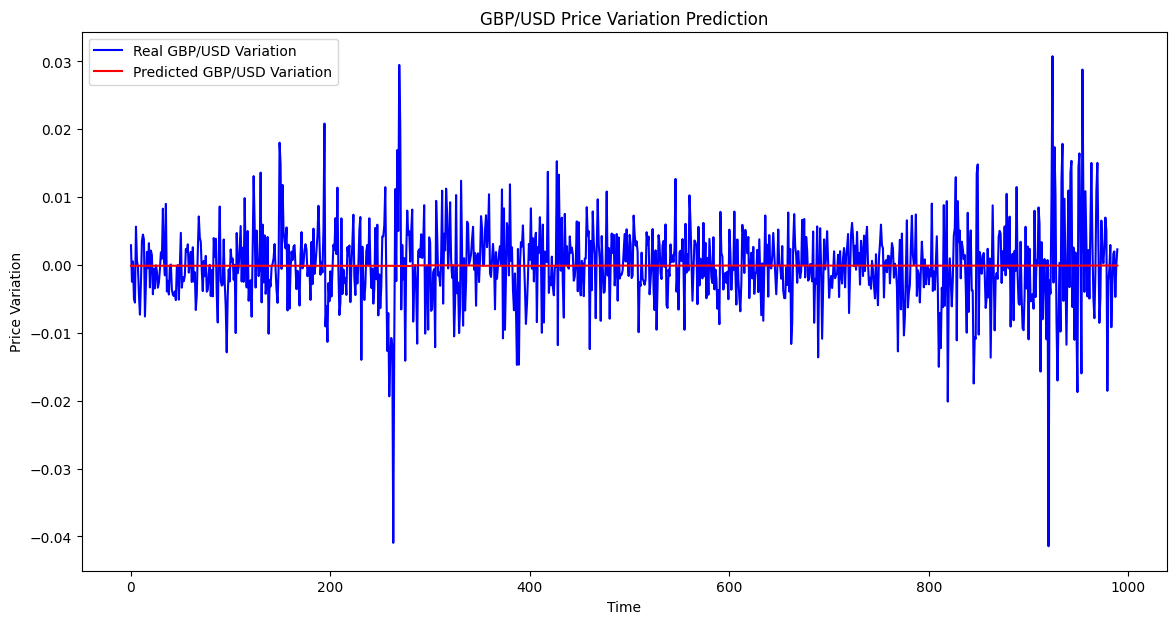

In [18]:
# Hacer predicciones en el conjunto de prueba
y_pred_gbpusd = model_gbpusd.predict(X_test_gbpusd)
y_pred_gbpusd = scaler_target_gbpusd.inverse_transform(y_pred_gbpusd)
y_test_gbpusd = scaler_target_gbpusd.inverse_transform(y_test_gbpusd)

# Graficar los resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test_gbpusd, color='blue', label='Real GBP/USD Variation')
plt.plot(y_pred_gbpusd, color='red', label='Predicted GBP/USD Variation')
plt.title('GBP/USD Price Variation Prediction')
plt.xlabel('Time')
plt.ylabel('Price Variation')
plt.legend()
plt.show()
